# Prognozowanie cen samochodów

* rozwiązanie zadania konkursowego Data Science Master Class (DataWorkshop) https://www.kaggle.com/c/masterclass3-predict-car-price

In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error

import eli5
from tqdm import tqdm
import re

### wczytanie danych 

In [2]:
df_train = pd.read_hdf("../input/df.train.h5")

df_train["price_value"] = df_train['price_value'].apply(lambda x: float(x.replace(" ", "").replace(",", ".")))

df_test = pd.read_hdf("../input/df.test.h5")

print(df_train.shape, df_test.shape)

(80129, 10) (80129, 7)


In [5]:
df_train.head()

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
7,7,"Cena Brutto, Faktura VAT",63900.0,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",TRANS-AUTO SP. Z O.O. DEALER MARKI ...,Dealer,"ŁUKASIEWICZA 1 - 19-300 Ełk, ełcki, Warmińsko-...","[Osobowe, Citroën, C4 Cactus]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
10,10,Cena Brutto,41900.0,PLN,"[ABS, ASR (kontrola trakcji), Elektryczne szyb...",DECAR - RENAULT i DACIA,Dealer,"MODLIŃSKA 154 B - 03-170 Warszawa, Mazowieckie...","[Osobowe, Nissan, Juke]","{'Kolor': 'Czarny', 'Model pojazdu': 'Juke', '..."
11,11,"Cena Brutto, Do negocjacji",17950.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",SKUP SPRZEDAŻ ZAMIANA RATY,Dealer,"Ruchocinek 63c - 62-230 Witkowo, gnieźnieński,...","[Osobowe, Opel, Astra, Opel Astra H (2004-2014)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
14,14,"Cena Brutto, Do negocjacji",38000.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Chróścice, opolski, Opolskie","[Osobowe, Audi, A4, Audi A4 B8 (2007-2015)]","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Ni..."
16,16,Cena Brutto,21900.0,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Trzeboszowice, nyski, Opolskie","[Osobowe, Ford, Fiesta, Ford Fiesta Mk7 (2008-)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."


In [ ]:
df_train = df_train[ df_train.index != 106447 ].reset_index(drop=True)  # usunięty outlier

* w zmiennej docelowej nadal widać outliery, dlatego może pomóc transformacja logarytmiczna

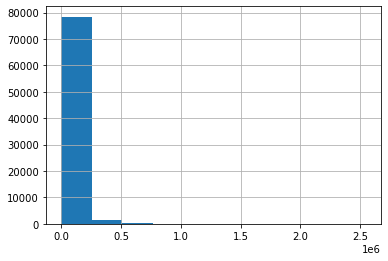

In [17]:
df_train['price_value'].hist();

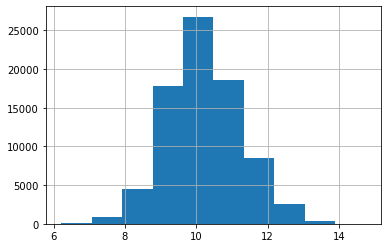

In [18]:
np.log(df_train['price_value']).hist();

In [9]:
# przykład cech w offer_params
df_train['offer_params'][7]

{'Bezwypadkowy': 'Tak',
 'Liczba miejsc': '5',
 'Kraj pochodzenia': 'Polska',
 'Pojemność skokowa': '1 199 cm3',
 'Rodzaj paliwa': 'Benzyna',
 'Skrzynia biegów': 'Manualna',
 'Możliwość finansowania': 'Tak',
 'Pierwszy właściciel': 'Tak',
 'Oferta od': 'Firmy',
 'Liczba drzwi': '5',
 'Przebieg': '200 km',
 'Moc': '110 KM',
 'Metalik': 'Tak',
 'Typ': 'Kompakt',
 'Kolor': 'Czarny',
 'Model pojazdu': 'C4 Cactus',
 'Stan': 'Używane',
 'Kategoria': 'Osobowe',
 'Serwisowany w ASO': 'Tak',
 'Napęd': 'Na przednie koła',
 'Leasing': 'Tak',
 'Rok produkcji': '2017',
 'Marka pojazdu': 'Citroën',
 'Faktura VAT': 'Tak',
 'Pierwsza rejestracja': '15 listopad 2017',
 'Zarejestrowany w Polsce': 'Tak'}

### offer_params - zamiana cech kategorialnych na reprezentację liczbową

* wydobycie cech z kolumny offer_params

In [3]:
df = pd.concat([df_train, df_test])

    
if "Bezwypadkowy" not in df:
    params = df["offer_params"].apply(pd.Series)
    params = params.fillna(-1)
    
    df = pd.concat([df, params], axis=1)
    print(df.shape)
    
    obj_feats = params.select_dtypes(object).columns

    for feat in obj_feats:
        df["{}_cat".format(feat)] = df[feat].factorize()[0]
    
cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

(160257, 86)


['Bezwypadkowy_cat',
 'Liczba miejsc_cat',
 'Kraj pochodzenia_cat',
 'Pojemność skokowa_cat',
 'Rodzaj paliwa_cat',
 'Skrzynia biegów_cat',
 'Możliwość finansowania_cat',
 'Pierwszy właściciel_cat',
 'Oferta od_cat',
 'Liczba drzwi_cat',
 'Przebieg_cat',
 'Moc_cat',
 'Metalik_cat',
 'Typ_cat',
 'Kolor_cat',
 'Model pojazdu_cat',
 'Stan_cat',
 'Kategoria_cat',
 'Serwisowany w ASO_cat',
 'Napęd_cat',
 'Leasing_cat',
 'Rok produkcji_cat',
 'Marka pojazdu_cat',
 'Faktura VAT_cat',
 'Pierwsza rejestracja_cat',
 'Zarejestrowany w Polsce_cat',
 'VAT marża_cat',
 'Wersja_cat',
 'VIN_cat',
 'Perłowy_cat',
 'Uszkodzony_cat',
 'Kod Silnika_cat',
 'Filtr cząstek stałych_cat',
 'Emisja CO2_cat',
 'Miesięczna rata_cat',
 'Liczba pozostałych rat_cat',
 'Opłata początkowa_cat',
 'Wartość wykupu_cat',
 'Akryl (niemetalizowany)_cat',
 'Tuning_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Homologacja ciężarowa_cat',
 'Make_cat',
 'Metallic_cat',
 'Engine capacity_cat',
 'Version_cat',
 'VAT discount_cat'

* Na liście cech widać, że niektóre z nich się powtarzają w wersji polskiej i angielskiej. Można je ze sobą połączyć.

## feature engineering 

In [7]:
# cechy kategorialne
feats1 = ['Marka pojazdu', 'Metalik', 'Wersja', 'Bezwypadkowy', 'Serwisowany w ASO', 'Rodzaj paliwa',
         'Skrzynia biegów', 'Napęd', 'Model pojazdu', 'Kolor', 'Kraj pochodzenia', 'Typ', 'Akryl (niemetalizowany)',
         'Możliwość finansowania', 'Zarejestrowany w Polsce', 'Pierwszy właściciel', 'Perłowy', 'Kod Silnika',
         'Filtr cząstek stałych', 'Leasing', 'Uszkodzony']

feats2 = ['Make', 'Metallic', 'Version', 'No accident', 'Service record', 'Fuel type',
         'Gearbox', 'Transmission', 'Model', 'Color', 'Country of origin', 'Body type', 'Acrylic',
         'Financing option', 'Registered in Poland', 'Original owner', 'Pearl', 'Engine Code',
         'Particle filter', 'Leasing concession', 'Damaged']

# cechy liczbowe
feats1_num = ['Pojemność skokowa', 'Przebieg', 'Liczba drzwi', 'Liczba miejsc', 'Rok produkcji', 'Emisja CO2',
              'Miesięczna rata', 'Pierwsza rejestracja']
feats2_num = ['Engine capacity', 'Mileage', 'Door count', 'Nr of seats', 'Year', 'CO2 emissions',
              'Monthly payment value', 'First registration']


In [9]:
# UWAGA
# Engine power i Moc - rozne jednostki, przed zmergowaniem trzeba przeliczyc Engine power z HP na KM

df['Engine power_num'] = df['Engine power'].apply(lambda x: int(x.split("HP")[0].replace(" ", "")) if x != -1 else -1)
df['Moc_num'] = df['Moc'].apply(lambda x: int(x.split("KM")[0].replace(" ", "")) if x != -1 else -1)

df['Engine power_km'] = df['Engine power_num'].apply(lambda x: x * 1.0139 if x != -1 else -1).astype(int)
df['Moc_num'] = df[['Moc_num', 'Engine power_km']].apply(lambda x: x['Moc_num'] if x['Moc_num'] != -1 else x['Engine power_km'], axis=1)
model_feats.append('Moc_num')

In [10]:
# łączenie cech angielskich z polskimi
def join_feats_and_make_num(feat1, feat2, is_num=False):
    df["{}_new".format(feat1)] = df[[feat1, feat2]].apply(lambda x: x[feat1] if x[feat1] != -1 else x[feat2], axis=1)
    if is_num == False:
        df["{}_new_cat".format(feat1)] = df["{}_new".format(feat1)].factorize()[0]

In [11]:
for f1, f2 in zip(feats1, feats2):
    join_feats_and_make_num(f1, f2)
    model_feats.append("{}_new_cat".format(f1))

In [12]:
for f1, f2 in zip(feats1_num, feats2_num):
    join_feats_and_make_num(f1, f2, is_num=True)

In [13]:
df['Pojemność skokowa_num'] = df['Pojemność skokowa_new'].apply(lambda x: int(x.split("cm3")[0].replace(" ", "")) if x != -1 else -1)
df['Przebieg_num'] = df['Przebieg_new'].apply(lambda x: int(x.split("km")[0].replace(" ", "")) if x != -1 else -1)
df['Liczba drzwi_num'] = df['Liczba drzwi_new'].astype(int)
df['Liczba miejsc_num'] = df['Liczba miejsc_new'].astype(int)
df['Rok produkcji_num'] = df['Rok produkcji_new'].astype(int)
df['Emisja CO2_num'] = df['Emisja CO2_new'].apply(lambda x: int(x.split("g/km")[0].replace(" ", "")) if x != -1 else -1)
df['Miesięczna rata_num'] = df['Miesięczna rata_new'].apply(lambda x: float(x.split("PLN")[0].replace(" ", "").replace(",", ".")) if x != -1 else -1)
df['Rok_pierwszej_rejestracji'] = df['Pierwsza rejestracja_new'].apply(lambda x: x.split(" ")[-1] if x != -1 else -1).astype(int)
df['Liczba pozostałych rat_num'] = df['Liczba pozostałych rat'].apply(lambda x: int(str(x).replace(" ", "")) if (x != '3 482,92') and (x != '8 926') else -1)
df['Opłata początkowa_num'] = df['Opłata początkowa'].apply(lambda x: float(x.split("PLN")[0].replace(" ", "").replace(",", ".")) if x != -1 else -1)
df['Wartość wykupu_num'] = df['Wartość wykupu'].apply(lambda x: float(x.split("PLN")[0].replace(" ", "").replace(",", ".")) if x != -1 else -1)

In [20]:
df['Matowy'].value_counts()

-1      159755
Tak        500
matt         2
Name: Matowy, dtype: int64

In [21]:
df['Matowy'] = df['Matowy'].apply(lambda x: x if x != 'matt' else 'Tak')
df['Matowy_cat'] = df['Matowy'].factorize()[0]

df['Metalik_new'] = df['Metalik_new'].apply(lambda x: x if x != 'metallic' else 'Tak')
df['Metalik_new_cat'] = df['Metalik_new'].factorize()[0]

df['Akryl (niemetalizowany)_new'] = df['Akryl (niemetalizowany)_new'].apply(lambda x: x if x != 'acrylic' else 'Tak')
df['Akryl (niemetalizowany)_new_cat'] = df['Akryl (niemetalizowany)_new'].factorize()[0]

## features

#### Przydatny link - Jak radzić sobie z listami w kolumnie
https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

In [31]:
df['num_features'] = df['features'].apply(lambda x: len(x) if x != -1 else -1)
model_feats.append('num_features')

In [33]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [34]:
# lista unikalnych wartości jakie występują na liście features
unique_features = list(set(to_1D(df["features"]).values))
unique_features

['Podgrzewane tylne siedzenia',
 'Bluetooth',
 'Relingi dachowe',
 'Radio niefabryczne',
 'System Start-Stop',
 'Poduszka powietrzna chroniąca kolana',
 'Alarm',
 'ESP (stabilizacja toru jazdy)',
 'Czujnik zmierzchu',
 'Gniazdo SD',
 'Odtwarzacz DVD',
 'Elektrycznie ustawiane lusterka',
 'Tapicerka welurowa',
 'CD',
 'Szyberdach',
 'Czujnik martwego pola',
 'Klimatyzacja dwustrefowa',
 'Isofix',
 'Tempomat',
 'Podgrzewane przednie siedzenia',
 'Łopatki zmiany biegów',
 'Elektrycznie ustawiane fotele',
 'Poduszka powietrzna kierowcy',
 'ABS',
 'Czujnik deszczu',
 'Poduszki boczne przednie',
 'Przyciemniane szyby',
 'Elektryczne szyby tylne',
 'Alufelgi',
 'Tempomat aktywny',
 'Kurtyny powietrzne',
 'Zmieniarka CD',
 'Tapicerka skórzana',
 'MP3',
 'Gniazdo USB',
 'Ogranicznik prędkości',
 'Komputer pokładowy',
 'Elektrochromatyczne lusterka boczne',
 'Kamera cofania',
 'Poduszka powietrzna pasażera',
 'Światła do jazdy dziennej',
 'Światła przeciwmgielne',
 'Podgrzewana przednia szyba',


In [35]:
len(unique_features)

70

In [36]:
def boolean_df(item_lists, unique_items):
    bool_dict = {}
    
    for i, item in enumerate(unique_items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    return pd.DataFrame(bool_dict)

In [37]:
feats_bool = boolean_df(df['features'], unique_features)
feats_bool = feats_bool.astype(int)

In [39]:
feats_bool

,Podgrzewane tylne siedzenia,Bluetooth,Relingi dachowe,Radio niefabryczne,System Start-Stop,Poduszka powietrzna chroniąca kolana,Alarm,ESP (stabilizacja toru jazdy),Czujnik zmierzchu,Gniazdo SD,...,Klimatyzacja czterostrefowa,Nawigacja GPS,Poduszki boczne tylne,Czujniki parkowania przednie,Wielofunkcyjna kierownica,Immobilizer,Hak,Ogrzewanie postojowe,Podgrzewane lusterka boczne,Radio fabryczne
0,0,1,1,0,1,0,0,1,1,0,...,0,1,0,0,1,1,0,0,1,1
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,1,0,0,0,1
2,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,1,1,0,0,1,1
3,0,0,0,0,0,0,0,1,1,0,...,0,1,1,0,1,1,0,0,1,1
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160245,0,1,1,0,1,0,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
160246,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
160247,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
160251,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,1,1


In [41]:
df.shape

(160257, 228)

In [42]:
df = pd.concat([df, feats_bool], axis=1)

In [43]:
df.shape

(160257, 298)

In [44]:
bool_feats = list(feats_bool.columns)

In [47]:
# sprawdzenie czy wśród kolumn z featurami występują takie, które przyjmują zawsze tą samą wartość
for f in feats_bool.columns:
    print(f, '\n', feats_bool[f].value_counts(), '\n')

Podgrzewane tylne siedzenia 
 0    154870
1      5387
Name: Podgrzewane tylne siedzenia, dtype: int64 

Bluetooth 
 0    95676
1    64581
Name: Bluetooth, dtype: int64 

Relingi dachowe 
 0    117392
1     42865
Name: Relingi dachowe, dtype: int64 

Radio niefabryczne 
 0    149855
1     10402
Name: Radio niefabryczne, dtype: int64 

System Start-Stop 
 0    128997
1     31260
Name: System Start-Stop, dtype: int64 

Poduszka powietrzna chroniąca kolana 
 0    129124
1     31133
Name: Poduszka powietrzna chroniąca kolana, dtype: int64 

Alarm 
 1    83767
0    76490
Name: Alarm, dtype: int64 

ESP (stabilizacja toru jazdy) 
 1    103209
0     57048
Name: ESP (stabilizacja toru jazdy), dtype: int64 

Czujnik zmierzchu 
 0    97260
1    62997
Name: Czujnik zmierzchu, dtype: int64 

Gniazdo SD 
 0    133261
1     26996
Name: Gniazdo SD, dtype: int64 

Odtwarzacz DVD 
 0    145014
1     15243
Name: Odtwarzacz DVD, dtype: int64 

Elektrycznie ustawiane lusterka 
 1    136143
0     24114
Name

In [68]:
pd.pivot_table(df, index=["Napęd_new"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Napęd_new,,,,,
4x4 (stały),144701.883485,92900.0,2200.0,2193400.0,10665.0
4x4 (dołączany automatycznie),116262.091076,78900.0,2900.0,1886929.0,10366.0
Na tylne koła,61592.647051,29994.5,1000.0,2178000.0,12966.0
4x4 (dołączany ręcznie),47536.258892,28200.0,2200.0,1179183.0,2419.0
Na przednie koła,32810.599668,21999.0,500.0,2545412.0,99487.0
-1,34106.287605,18900.0,650.0,1350000.0,24354.0


In [70]:
df['Napęd_4x4'] = df['Napęd_new'].apply(lambda x: 1 if (x == '4x4 (stały)') | (x == '4x4 (dołączany automatycznie)') else 0)
df['Napęd_4x4'].value_counts()

0    139226
1     21031
Name: Napęd_4x4, dtype: int64

In [69]:
pd.pivot_table(df, index=["Marka pojazdu_new"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False).head(20)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Lamborghini,1.123293e+06,999900.0,179000.0,2193400.0,24.0
Ferrari,7.049447e+05,659000.0,35000.0,2178000.0,37.0
McLaren,5.720000e+05,572000.0,572000.0,572000.0,4.0
Maybach,4.890000e+05,489000.0,489000.0,489000.0,1.0
Bentley,5.213429e+05,482000.0,29000.0,1170000.0,41.0
Tesla,3.408926e+05,391750.0,85999.0,508882.0,26.0
Aston Martin,4.358697e+05,352448.5,108000.0,975000.0,22.0
Rolls-Royce,5.173328e+05,347500.0,59000.0,1490000.0,9.0
Maserati,2.935604e+05,299900.0,38900.0,745000.0,93.0


In [61]:
drogie_marki = list(pd.pivot_table(df, index=["Marka pojazdu_new"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False).head(20).index)
drogie_marki

['Lamborghini',
 'Ferrari',
 'McLaren',
 'Maybach',
 'Bentley',
 'Tesla',
 'Aston Martin',
 'Rolls-Royce',
 'Maserati',
 'Porsche',
 'Morgan',
 'Infiniti',
 'Isuzu',
 'Lexus',
 'Land Rover',
 'Jeep',
 'Hummer',
 'GMC',
 'Jaguar',
 'Plymouth']

In [63]:
df['droga_marka'] = df['Marka pojazdu_new'].apply(lambda x: 1 if x in drogie_marki else 0)

In [76]:
df["Wersja_new"]

0                      -1
1                      -1
2           H (2004-2014)
3          B8 (2007-2015)
4             Mk7 (2008-)
               ...       
160245     B7 (2010-2014)
160246         II (2014-)
160247      I (2002-2010)
160251                 -1
160254    III (2001-2006)
Name: Wersja_new, Length: 160257, dtype: object

In [66]:
# z wersji można wyodrębnić lata w jakich była produkowana dana wersja
df["version_years"] = df["Wersja_new"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)) )
df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)

df[ ["version_year_from", "version_year_to"] ]

,version_year_from,version_year_to
0,-1,-1
1,-1,-1
2,2004,2014
3,2007,2015
4,2008,-1
...,...,...
160245,2010,2014
160246,2014,-1
160247,2002,2010
160251,-1,-1


In [67]:
df['Wersja_new_2'] = df['Wersja_new'].apply(lambda x: x.split(" ")[0] if x != -1 else -1)
df['Wersja_new_2_cat'] = df['Wersja_new_2'].factorize()[0]

In [95]:
df[['seller_type', 'Oferta od']][(df['seller_type'] == 'Dealer') & (df['Oferta od'] != 'Firmy')]

,seller_type,Oferta od
12311,Dealer,Osoby prywatnej
44926,Dealer,Osoby prywatnej
73977,Dealer,Osoby prywatnej
93844,Dealer,Osoby prywatnej
156973,Dealer,Osoby prywatnej


In [99]:
df[['seller_type', 'Oferta od']][(df['seller_type'] == 'Osoba prywatna') & (df['Oferta od'] != 'Osoby prywatnej')]

,seller_type,Oferta od


In [88]:
def wojewodztwo(adres):
    if 'dolnośląskie' in adres:
        return 1
    elif 'kujawsko-pomorskie' in adres:
        return 2
    elif 'lubelskie' in adres:
        return 3
    elif 'lubuskie' in adres:
        return 4
    elif 'łódzkie' in adres:
        return 5
    elif 'małopolskie' in adres:
        return 6
    elif 'mazowieckie' in adres:
        return 7
    elif 'opolskie' in adres:
        return 8
    elif 'podkarpackie' in adres:
        return 9
    elif 'podlaskie' in adres:
        return 10
    elif 'pomorskie' in adres:
        return 11
    elif ('śląskie' in adres) or ('slaskie' in adres):
        return 12
    elif 'świętokrzyskie' in adres:
        return 13
    elif 'warmińsko-mazurskie' in adres:
        return 14
    elif 'wielkopolskie' in adres:
        return 15
    elif 'zachodniopomorskie' in adres:
        return 16
    else:
        return -1

In [90]:
df['wojewodztwo'] = df['seller_address'].apply(lambda x: wojewodztwo(x.lower()))
df['wojewodztwo'].value_counts()

 8     24172
 7     22539
-1     20712
 12    16054
 11    12163
 6     12010
 1     10397
 5      8194
 2      6884
 3      6805
 9      5314
 13     5017
 14     3915
 4      3903
 10     2178
Name: wojewodztwo, dtype: int64

In [113]:
pd.pivot_table(df, index=["wojewodztwo"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
wojewodztwo,,,,,
-1,96406.347862,60900.0,699.0,2178000.0,20712.0
7,45989.945561,26500.0,599.0,2193400.0,22539.0
12,46649.060410,25900.0,650.0,1290000.0,16054.0
10,44224.215213,25850.0,1333.0,769000.0,2178.0
8,39429.156474,23500.0,800.0,936900.0,24172.0
11,42369.858853,23500.0,500.0,1041200.0,12163.0
9,41074.879390,22900.0,1000.0,614000.0,5314.0
6,38188.455556,22500.0,750.0,1179183.0,12010.0


### Grupowanie cech
* wśród cech binarnych można wyodrębnić kilka podobnych grup, np cechy dotyczące świateł, poduszek powietrznych itp. Można spróbować je połączyć ze sobą, ewentualnie nadać im pewne wagi, np. widać, że Dach panoramiczny jest bardziej popularny wśród droższych aut więc można nadać mu większą wagę niż dla szyberdachu

In [96]:
pd.pivot_table(df, index=["Światła Xenonowe"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Światła Xenonowe,,,,,
1,68341.558551,45900.0,999.0,2178000.0,30747.0
0,43614.281059,21900.0,500.0,2545412.0,129510.0


In [95]:
pd.pivot_table(df, index=["Światła LED"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Światła LED,,,,,
1,103584.733462,72450.0,999.0,2193400.0,35367.0
0,32682.184751,19900.0,500.0,2545412.0,124890.0


In [92]:
pd.pivot_table(df, index=["Dach panoramiczny"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Dach panoramiczny,,,,,
1,98640.947836,51400.0,999.0,2178000.0,12411.0
0,44200.698105,24100.0,500.0,2545412.0,147846.0


In [93]:
pd.pivot_table(df, index=["Szyberdach"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Szyberdach,,,,,
1,73856.513047,39000.0,900.0,1659842.0,14304.0
0,45880.850523,24900.0,500.0,2545412.0,145953.0


In [94]:
pd.pivot_table(df, index=["Relingi dachowe"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Relingi dachowe,,,,,
1,54739.930845,32900.0,999.0,1659842.0,42865.0
0,46025.162645,23000.0,500.0,2545412.0,117392.0


In [247]:
pd.pivot_table(df, index=["Tempomat"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Tempomat,,,,,
1,58314.945212,35900.0,813.0,2545412.0,84209.0
0,37301.339260,16900.0,500.0,2178000.0,76048.0


In [248]:
pd.pivot_table(df, index=["Tempomat aktywny"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Tempomat aktywny,,,,,
1,126451.447012,87700.0,999.0,2178000.0,10646.0
0,42750.969226,23900.0,500.0,2545412.0,149611.0


In [249]:
pd.pivot_table(df, index=["Ogranicznik prędkości"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Ogranicznik prędkości,,,,,
1,83097.015447,54870.0,813.0,1659842.0,25959.0
0,41601.026898,21900.0,500.0,2545412.0,134298.0


In [98]:
df['parkowanie'] = df['Kamera cofania'] + df['Czujniki parkowania przednie'] + df['Czujnik martwego pola'] + df['Czujniki parkowania tylne'] + df['Asystent parkowania']
df['klimatyzacja'] = df['Klimatyzacja manualna'] + 2 * df['Klimatyzacja automatyczna'] + 2 * df['Klimatyzacja czterostrefowa'] + df['Klimatyzacja dwustrefowa']
df['podgrzewanie'] = df['Podgrzewana przednia szyba'] + df['Podgrzewane przednie siedzenia'] + df['Podgrzewane tylne siedzenia'] + df['Ogrzewanie postojowe'] + df['Podgrzewane lusterka boczne']
df['poduszki'] = df['Poduszki boczne przednie'] + df['Poduszka powietrzna chroniąca kolana'] + df['Poduszki boczne tylne'] + df['Poduszka powietrzna kierowcy'] + df['Poduszka powietrzna pasażera']
df['wspomaganie'] = df['ASR (kontrola trakcji)'] + df['Wspomaganie kierownicy'] + df['ESP (stabilizacja toru jazdy)'] + df['ABS'] + df['Asystent pasa ruchu']
df['tapicerka'] = df['Tapicerka welurowa'] + 2 * df['Tapicerka skórzana']
df['światła_dzienne_mgla'] = df['Światła do jazdy dziennej'] + df['Światła przeciwmgielne']
df['czujniki'] = df['Czujnik deszczu'] + df['Czujnik zmierzchu']
df['tempomat'] = df['Tempomat'] + 2 * df['Ogranicznik prędkości'] + 3 * df['Tempomat aktywny']
df['szyby'] = df['Elektryczne szyby przednie'] + df['Elektryczne szyby tylne']
df['radio'] = df['Radio niefabryczne'] + 2 * df['Radio fabryczne']
df['media'] = df['CD'] + df['Odtwarzacz DVD'] + df['Zmieniarka CD'] + df['Tuner TV'] + df['Gniazdo AUX'] + df['Gniazdo USB'] + df['MP3'] + df['Bluetooth'] + df['Gniazdo SD']
df['lusterka'] = df['Elektrycznie ustawiane lusterka'] + df['Elektrochromatyczne lusterka boczne'] + df['Elektrochromatyczne lusterko wsteczne']
df['dach'] = df['Relingi dachowe'] + 2 * df['Szyberdach'] + 3 * df['Dach panoramiczny']
df['światła'] = df['Światła Xenonowe'] + 2 * df['Światła LED']
df['zamek'] = df['Centralny zamek'] + 2 * df['Alarm']
df['wyglad'] = df['Alufelgi'] + df['Przyciemniane szyby']

In [118]:
pd.pivot_table(df, index=["Rok produkcji_num"], values=["price_value"], aggfunc=["mean", "median", "min", "max", len]).sort_values(by=('median', 'price_value'), ascending=False)

,mean,median,min,max,len
,price_value,price_value,price_value,price_value,price_value
Rok produkcji_num,,,,,
1957,750000.000000,750000.0,750000.0,750000.0,1.0
2018,149472.938468,111934.0,30900.0,2193400.0,3549.0
2017,140745.864632,103250.0,1450.0,2178000.0,17724.0
2016,106799.631380,77900.0,1600.0,2050000.0,7157.0
1952,76950.000000,76950.0,54000.0,99900.0,6.0
...,...,...,...,...,...
1941,NaN,NaN,NaN,NaN,1.0
1942,NaN,NaN,NaN,NaN,1.0


In [123]:
df['new'] = df['Rok produkcji_num'].apply(lambda x: 1 if x >= 2016 else 0)
df['new_4x4'] = df['new'] + df['Napęd_4x4']

In [152]:
df['diff_produkcja_rejestracja'] = df[['Rok_pierwszej_rejestracji', 'Rok produkcji_num']].apply(lambda x: x['Rok_pierwszej_rejestracji'] - x['Rok produkcji_num'] if x['Rok_pierwszej_rejestracji'] != -1 else -300, axis=1)
df[(df['diff_produkcja_rejestracja'] < -1) & (df['diff_produkcja_rejestracja'] != -300)][['diff_produkcja_rejestracja', 'Rok_pierwszej_rejestracji', 'Rok produkcji_num', 'Pierwsza rejestracja', 'Uszkodzony', 'Bezwypadkowy']]

,diff_produkcja_rejestracja,Rok_pierwszej_rejestracji,Rok produkcji_num,Pierwsza rejestracja,Uszkodzony,Bezwypadkowy
2778,-10,1993,2003,5 czerwiec 1993,-1,Tak
5055,-10,1993,2003,12 wrzesień 1993,-1,Tak
7925,-2,2008,2010,sierpień 2008,-1,Tak
8694,-3,2004,2007,19 styczeń 2004,-1,Tak
8805,-264,1753,2017,styczeń 1753,-1,Tak
...,...,...,...,...,...,...
133818,-6,2001,2007,7 styczeń 2001,-1,Tak
136488,-24,1993,2017,12 lipiec 1993,-1,-1
142779,-3,2013,2016,marzec 2013,-1,Tak
148457,-2,2008,2010,27 sierpień 2008,-1,-1


### redukcja wartości odstających 

In [72]:
def reset_outliers(df, feat, prc=99):
    cut_value = np.percentile(df[feat], prc)
    
    return df[feat].map(lambda x: x if x < cut_value else -1)

<AxesSubplot:>

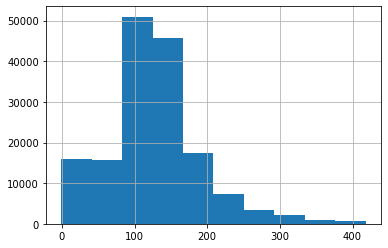

In [74]:
df['Moc_num_99'] = reset_outliers(df, 'Moc_num')
df['Moc_num_99'].hist()

<AxesSubplot:>

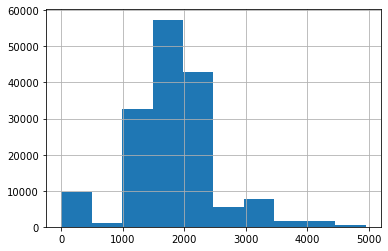

In [76]:
df['Pojemność skokowa_99'] = reset_outliers(df, 'Pojemność skokowa_num')
df['Pojemność skokowa_99'].hist()

<AxesSubplot:>

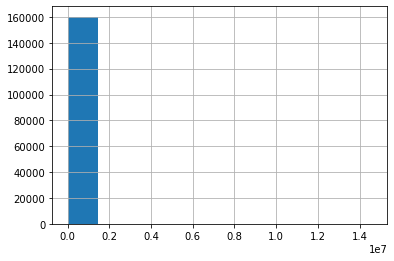

In [77]:
df['Przebieg_num'].hist()

<AxesSubplot:>

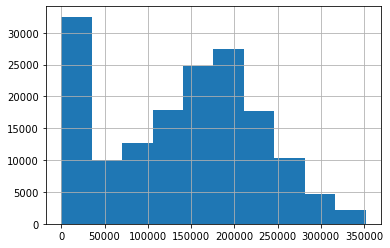

In [79]:
df['Przebieg_num_99'] = reset_outliers(df, 'Przebieg_num')
df['Przebieg_num_99'].hist()

<AxesSubplot:>

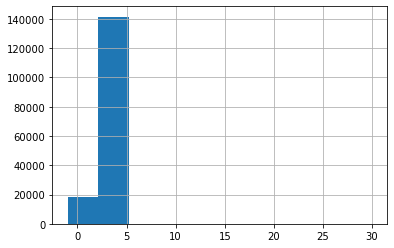

In [80]:
df['Liczba drzwi_num'].hist()

In [81]:
df[df['Liczba drzwi_num'] > 5]['Liczba drzwi_num']

655       6
704       6
4870      6
4907      6
6542      6
         ..
153421    6
153564    6
153628    6
154668    6
155936    7
Name: Liczba drzwi_num, Length: 175, dtype: int64

<AxesSubplot:>

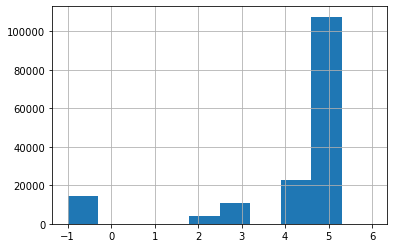

In [83]:
df['Liczba drzwi_num_99'] = reset_outliers(df, 'Liczba drzwi_num', 99.99)
df['Liczba drzwi_num_99'].hist()

<AxesSubplot:>

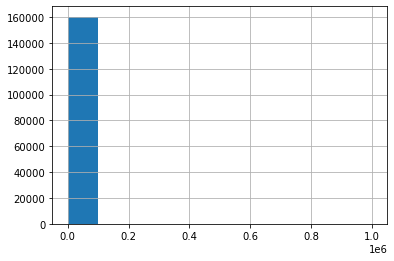

In [84]:
df['Emisja CO2_num'].hist()

<AxesSubplot:>

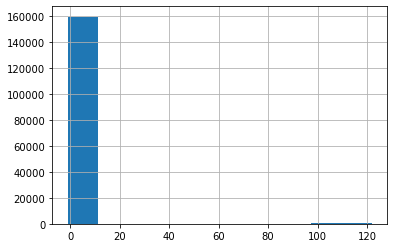

In [86]:
df['Emisja CO2_num_99'] = reset_outliers(df, 'Emisja CO2_num')
df['Emisja CO2_num_99'].hist()

## trenowanie i ocena modelu 

In [48]:
def check_log_model(df, feats, model, cv=5, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

In [156]:
# lista cech z finałowego modelu dającego najlepsze wyniki (Kaggle MAE = 6290 PLN)

model_feats = ['Moc_num_99',
 'Marka pojazdu_new_cat',
 'Metalik_new_cat',
 'Wersja_new_2_cat',
 'Bezwypadkowy_new_cat',
 'Serwisowany w ASO_new_cat',
 'Rodzaj paliwa_new_cat',
 'Skrzynia biegów_new_cat',
 'Napęd_new_cat',
 'Model pojazdu_new_cat',
 'Kolor_new_cat',
 'Kraj pochodzenia_new_cat',
 'Typ_new_cat',
 'Akryl (niemetalizowany)_new_cat',
 'Możliwość finansowania_new_cat',
 'Zarejestrowany w Polsce_new_cat',
 'Pierwszy właściciel_new_cat',
 'Perłowy_new_cat',
 'Kod Silnika_new_cat',
 'Filtr cząstek stałych_new_cat',
 'Leasing_new_cat',
 'Uszkodzony_new_cat',
 'Pojemność skokowa_99',
 'Przebieg_num_99',
 'Liczba drzwi_num_99',
 'Liczba miejsc_num',
 'Rok produkcji_num',
 'Emisja CO2_num_99',
 'Rok_pierwszej_rejestracji',
 'Oferta od_cat',
 'Stan_cat',
 'Faktura VAT_cat',
 'VAT marża_cat',
 'Tuning_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Homologacja ciężarowa_cat',
 'Matowy_cat',
 'Zarejestrowany jako zabytek_cat',
 'VAT discount_cat',
 'VAT free_cat',
 'num_features',
 'CD',
 'Elektrycznie ustawiane lusterka',
 'Elektryczne szyby przednie',
 'Nawigacja GPS',
 'Światła LED',
 'Relingi dachowe',
 'Ogranicznik prędkości',
 'Czujnik deszczu',
 'Tempomat',
 'System Start-Stop',
 'Gniazdo USB',
 'Przyciemniane szyby',
 'Elektryczne szyby tylne',
 'Komputer pokładowy',
 'Isofix',
 'Światła Xenonowe',
 'Czujnik zmierzchu',
 'ASR (kontrola trakcji)',
 'Alarm',
 'Centralny zamek',
 'Łopatki zmiany biegów',
 'Światła do jazdy dziennej',
 'Alufelgi',
 'Radio fabryczne',
 'Kurtyny powietrzne',
 'Elektrochromatyczne lusterka boczne',
 'Tapicerka welurowa',
 'Szyberdach',
 'Odtwarzacz DVD',
 'Dach panoramiczny',
 'Tuner TV',
 'Wspomaganie kierownicy',
 'Zmieniarka CD',
 'ESP (stabilizacja toru jazdy)',
 'ABS',
 'Gniazdo AUX',
 'Regulowane zawieszenie',
 'Asystent pasa ruchu',
 'Elektrycznie ustawiane fotele',
 'Radio niefabryczne',
 'Immobilizer',
 'MP3',
 'Elektrochromatyczne lusterko wsteczne',
 'Bluetooth',
 'Światła przeciwmgielne',
 'Tempomat aktywny',
 'Gniazdo SD',
 'Wielofunkcyjna kierownica',
 'HUD (wyświetlacz przezierny)',
 'Tapicerka skórzana',
 'Hak',
 'parkowanie',
 'klimatyzacja',
 'poduszki',
 'podgrzewanie',
 'droga_marka',
 'version_year_from',
 'version_year_to',
 'Napęd_4x4']

In [161]:
%%time
check_log_model(df, model_feats, xgb.XGBRegressor(max_depth=10, n_estimators=1000, learning_rate=0.1, random_state=0))

5it [50:27, 605.59s/it]


(6408.257183084371, 140.95018439211256)
CPU times: user 3h 43min 9s, sys: 10.8 s, total: 3h 43min 20s
Wall time: 1h 14min 39s


Weight,Feature
0.3638,Rok produkcji_num
0.0957,Napęd_new_cat
0.0704,Skrzynia biegów_new_cat
0.0617,Zarejestrowany jako zabytek_cat
0.0502,droga_marka
0.0483,Kierownica po prawej (Anglik)_cat
0.0347,Uszkodzony_new_cat
0.0208,Napęd_4x4
0.0128,Moc_num_99
0.0116,Światła Xenonowe


In [164]:
%%time

feats = model_feats
# log price version
df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price_value"]
y_train_log = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(max_depth=10, n_estimators=1000, learning_rate=0.1, random_state=0)
model.fit(X_train, y_train_log)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_9.csv", index=False)

CPU times: user 19min 56s, sys: 2.07 s, total: 19min 58s
Wall time: 6min 42s
